# Phase B Analysis: Causal Intervention Experiments

**Key Questions:**
1. **Sufficiency**: Does adding the reasoning subspace (α > 0) improve performance?
2. **Necessity**: Does removing/lesioning it (α < 0) harm performance?
3. **Specificity**: Is the learned subspace better than random directions?
4. **Rescue (ARA)**: Does Add-Remove-Add restore performance?

## 0. Setup

In [1]:
import sys
sys.path.insert(0, '.')
from pathlib import Path
import os
os.makedirs('../results/figures', exist_ok=True)
from phase_b_analysis_utils import *

import warnings
warnings.filterwarnings('ignore')
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')
print('Setup complete')

Setup complete


## 1. Load Data

In [2]:
PHASE_B_ROOT = Path('../results/phase_b')
df, ara_df = load_phase_b_data(PHASE_B_ROOT)

print('=== Grid Data (Add/Random interventions) ===')
print(f'Loaded {len(df)} configurations')
print(f'Models: {df["model"].unique().tolist()}')
print(f'Datasets: {df["dataset"].unique().tolist()}')
print(f'Modes: {df["mode"].unique().tolist()}')
print(f'Alpha values: {sorted(df["alpha"].unique().tolist())}')

print('\n=== ARA Data (Add-Remove-Add rescue) ===')
if len(ara_df) > 0:
    print(f'Loaded {len(ara_df)} ARA configurations')
    print(f'Models: {ara_df["model"].unique().tolist()}')
    print(f'Datasets: {ara_df["dataset"].unique().tolist()}')
else:
    print('No ARA data found')

=== Grid Data (Add/Random interventions) ===
Loaded 108 configurations
Models: ['Llama-3.1-8B-Instruct', 'Mistral-7B-Instruct-v0.3', 'Qwen2.5-7B-Instruct']
Datasets: ['arc', 'gsm8k', 'mmlu_pro']
Modes: ['add', 'random']
Alpha values: [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0]

=== ARA Data (Add-Remove-Add rescue) ===
Loaded 9 ARA configurations
Models: ['Llama-3.1-8B-Instruct', 'Mistral-7B-Instruct-v0.3', 'Qwen2.5-7B-Instruct']
Datasets: ['arc', 'gsm8k', 'mmlu_pro']


In [3]:
# Preview grid data
df.head()

,mode,layer,alpha,n,acc_base_answer,acc_intv_answer,delta_answer,answer_wrong_to_right,answer_right_to_wrong,answer_net_gain,...,delta_reasoning,reasoning_wrong_to_right,reasoning_right_to_wrong,reasoning_net_gain,acc_base_regex,acc_intv_regex,model,dataset,timestamp,run_dir
0,add,31,-2.0,20,0.85,0.85,0.0,0,0,0,...,-0.10,0,2,-2,0.85,0.85,Llama-3.1-8B-Instruct,arc,20251128_002630,../results/phase_b/Llama-3.1-8B-Instruct__intv...
1,add,31,-1.0,20,0.85,0.85,0.0,0,0,0,...,0.00,1,1,0,0.85,0.85,Llama-3.1-8B-Instruct,arc,20251128_002630,../results/phase_b/Llama-3.1-8B-Instruct__intv...
2,add,31,-0.5,20,0.85,0.85,0.0,0,0,0,...,0.05,2,1,1,0.85,0.85,Llama-3.1-8B-Instruct,arc,20251128_002630,../results/phase_b/Llama-3.1-8B-Instruct__intv...
3,add,31,0.0,20,0.85,0.85,0.0,0,0,0,...,0.10,2,0,2,0.85,0.85,Llama-3.1-8B-Instruct,arc,20251128_002630,../results/phase_b/Llama-3.1-8B-Instruct__intv...
4,add,31,0.5,20,0.85,0.85,0.0,0,0,0,...,0.00,2,2,0,0.85,0.85,Llama-3.1-8B-Instruct,arc,20251128_002630,../results/phase_b/Llama-3.1-8B-Instruct__intv...


In [4]:
# Preview ARA data
if len(ara_df) > 0:
    display(ara_df.head())

,mode,layer,n,pass1_acc_answer,pass2_acc_answer,pass3_acc_answer,pass1_acc_reasoning,pass2_acc_reasoning,pass3_acc_reasoning,consistent_p1_p3_answer,...,recovery_rate_answer,recovery_p1_p2_reasoning,recovery_rate_reasoning,pass1_acc_regex,pass2_acc_regex,pass3_acc_regex,model,dataset,timestamp,run_dir
0,ara,31,20,0.85,0.85,0.85,0.85,0.75,0.90,20,...,0.00,2,0.10,0.85,0.85,0.85,Llama-3.1-8B-Instruct,arc,20251128_011404,../results/phase_b/Llama-3.1-8B-Instruct__intv...
1,ara,31,20,0.15,0.20,0.15,0.40,0.50,0.40,20,...,0.05,2,0.10,0.15,0.15,0.15,Llama-3.1-8B-Instruct,gsm8k,20251128_051505,../results/phase_b/Llama-3.1-8B-Instruct__intv...
2,ara,31,20,0.40,0.40,0.40,0.80,0.75,0.85,20,...,0.00,1,0.05,0.05,0.05,0.05,Llama-3.1-8B-Instruct,mmlu_pro,20251128_030424,../results/phase_b/Llama-3.1-8B-Instruct__intv...
3,ara,31,20,0.75,0.75,0.75,0.70,0.75,0.75,20,...,0.00,1,0.05,0.75,0.75,0.75,Mistral-7B-Instruct-v0.3,arc,20251127_183656,../results/phase_b/Mistral-7B-Instruct-v0.3__i...
4,ara,31,20,0.15,0.15,0.15,0.15,0.10,0.20,20,...,0.00,1,0.05,0.20,0.20,0.20,Mistral-7B-Instruct-v0.3,gsm8k,20251127_230657,../results/phase_b/Mistral-7B-Instruct-v0.3__i...


## 2. Summary Statistics

In [5]:
summary = create_summary_table(df)
display(summary)

,model,dataset,mode,n_mean,acc_base_answer_mean,acc_intv_answer_mean,delta_answer_mean,delta_answer_std,delta_answer_count,answer_net_gain_sum
0,Llama-3.1-8B-Instruct,arc,add,20.0,0.850,0.850,0.000,0.000,7,0
1,Llama-3.1-8B-Instruct,arc,random,20.0,0.850,0.850,0.000,0.000,5,0
2,Llama-3.1-8B-Instruct,gsm8k,add,20.0,0.193,0.171,-0.021,0.049,7,-3
3,Llama-3.1-8B-Instruct,gsm8k,random,20.0,0.230,0.190,-0.040,0.065,5,-4
4,Llama-3.1-8B-Instruct,mmlu_pro,add,20.0,0.400,0.400,0.000,0.000,7,0
5,Llama-3.1-8B-Instruct,mmlu_pro,random,20.0,0.400,0.400,0.000,0.000,5,0
6,Mistral-7B-Instruct-v0.3,arc,add,20.0,0.750,0.750,0.000,0.000,7,0
7,Mistral-7B-Instruct-v0.3,arc,random,20.0,0.750,0.750,0.000,0.000,5,0
8,Mistral-7B-Instruct-v0.3,gsm8k,add,20.0,0.150,0.157,0.007,0.019,7,1
9,Mistral-7B-Instruct-v0.3,gsm8k,random,20.0,0.150,0.150,0.000,0.000,5,0


## 3. Alpha Sweep Plots

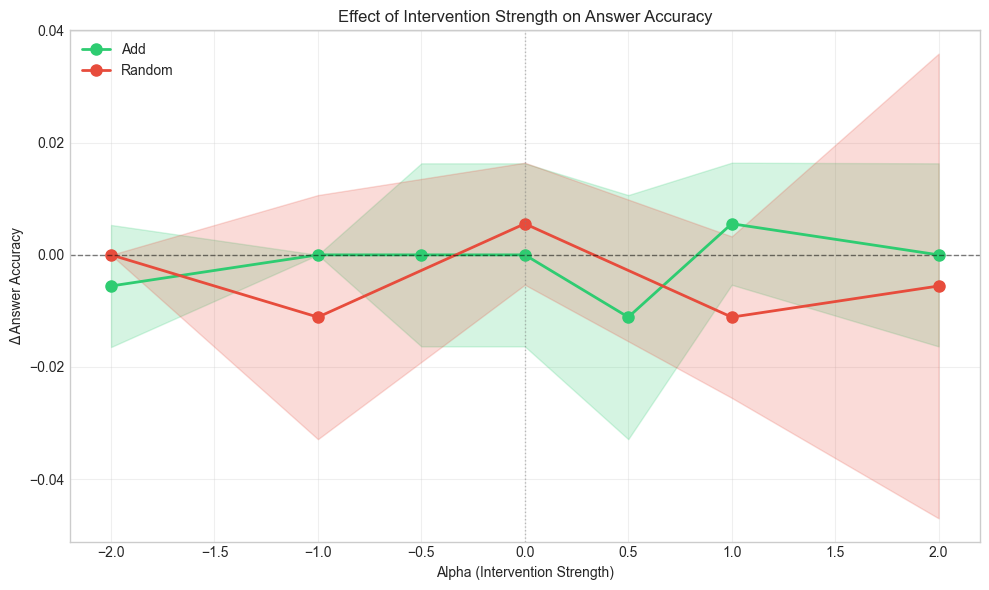

In [6]:
fig, ax = plot_alpha_sweep_overall(df, save_path=Path('../results/figures/alpha_sweep_overall.pdf'))
plt.show()

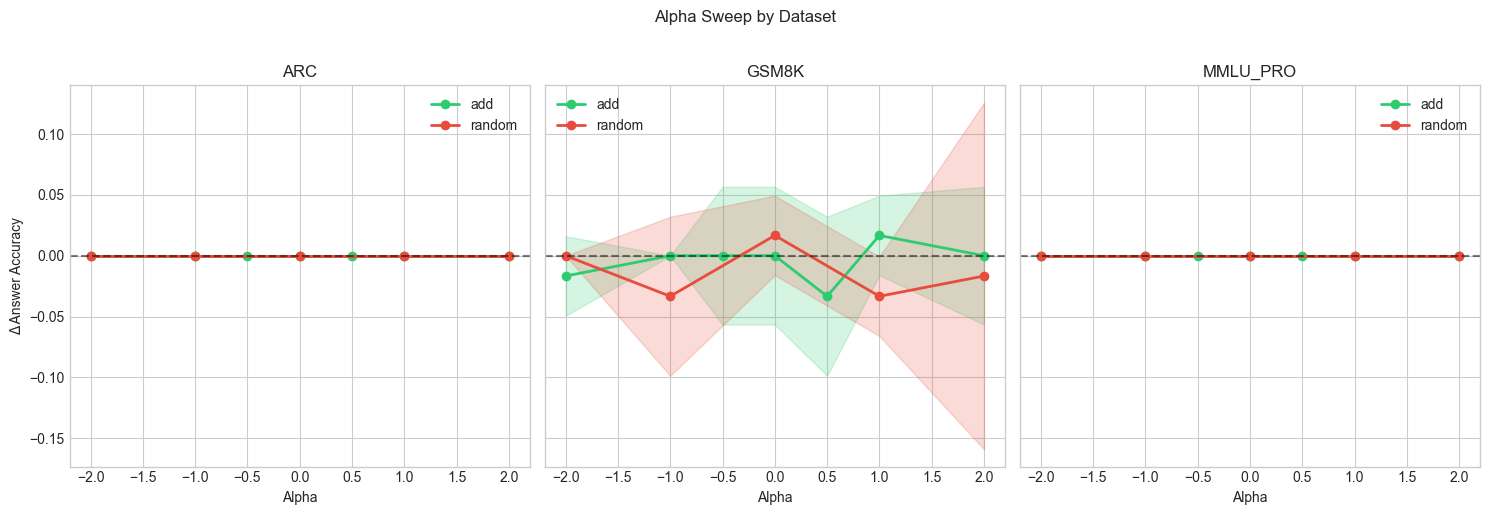

In [7]:
fig, axes = plot_alpha_sweep_by_dataset(df, save_path=Path('../results/figures/alpha_sweep_by_dataset.pdf'))
plt.show()

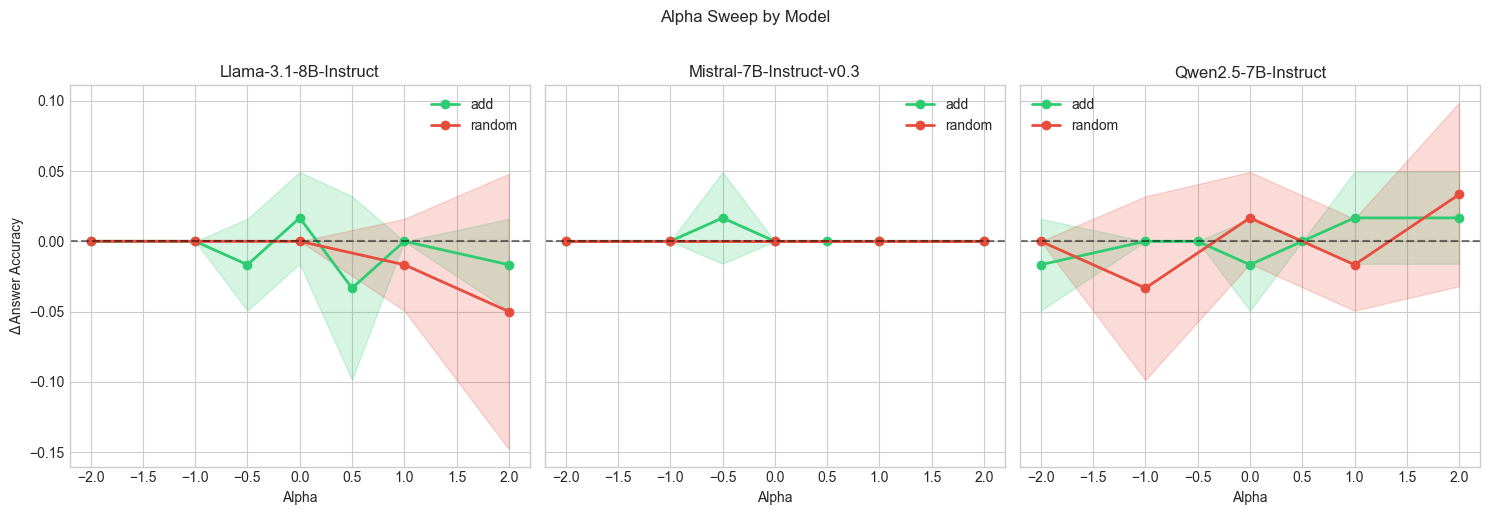

In [8]:
fig, axes = plot_alpha_sweep_by_model(df, save_path=Path('../results/figures/alpha_sweep_by_model.pdf'))
plt.show()

## 4. Heatmaps

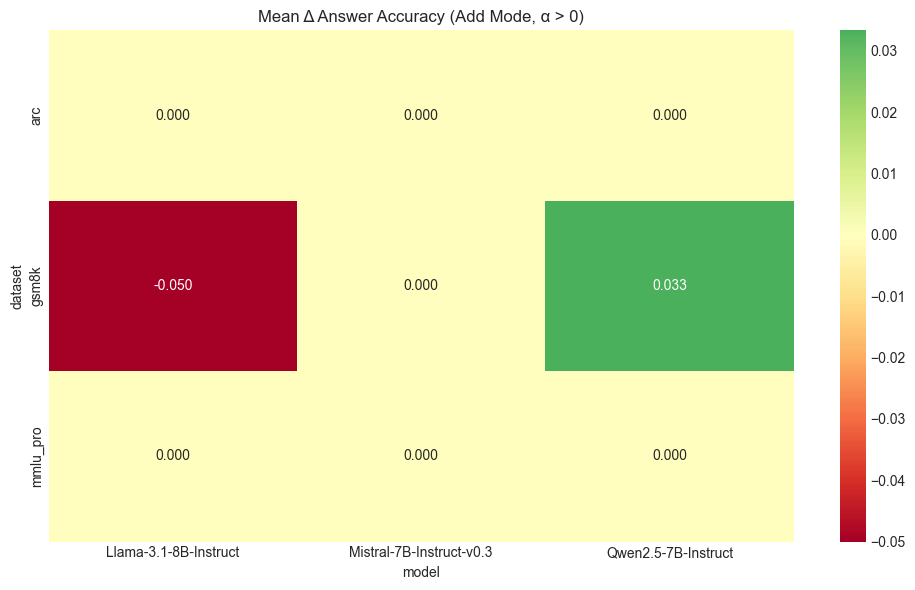

In [9]:
fig, ax = plot_heatmap_delta(df, mode='add', alpha_filter='positive', 
                              save_path=Path('../results/figures/heatmap_add_positive.pdf'))
plt.show()

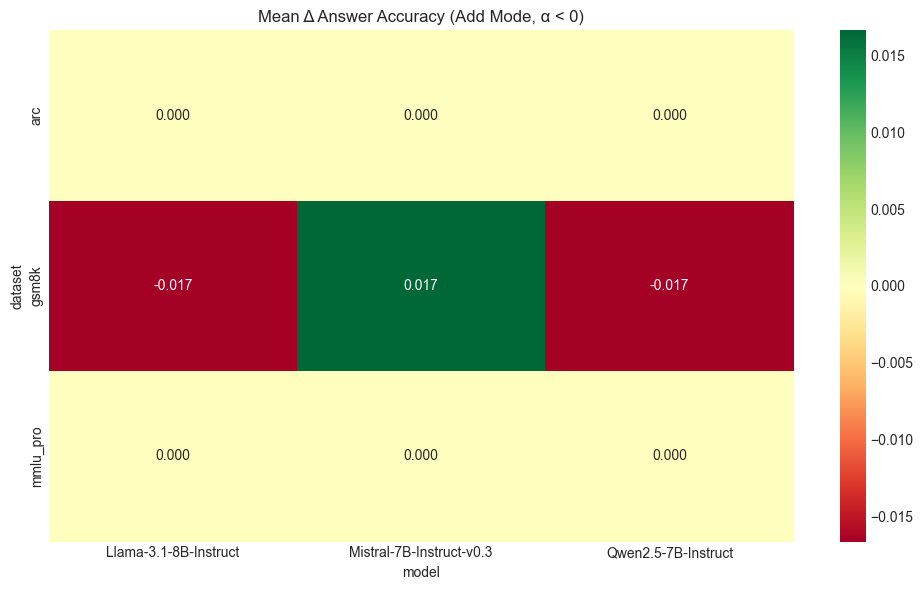

In [10]:
fig, ax = plot_heatmap_delta(df, mode='add', alpha_filter='negative',
                              save_path=Path('../results/figures/heatmap_add_negative.pdf'))
plt.show()

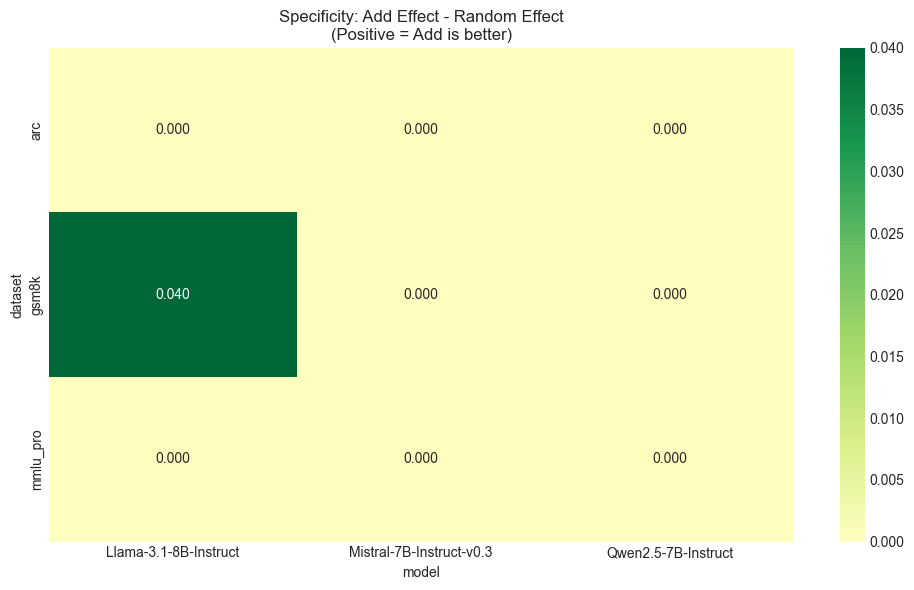

In [11]:
fig, ax = plot_heatmap_specificity(df, save_path=Path('../results/figures/heatmap_specificity.pdf'))
plt.show()

## 5. Flip Analysis

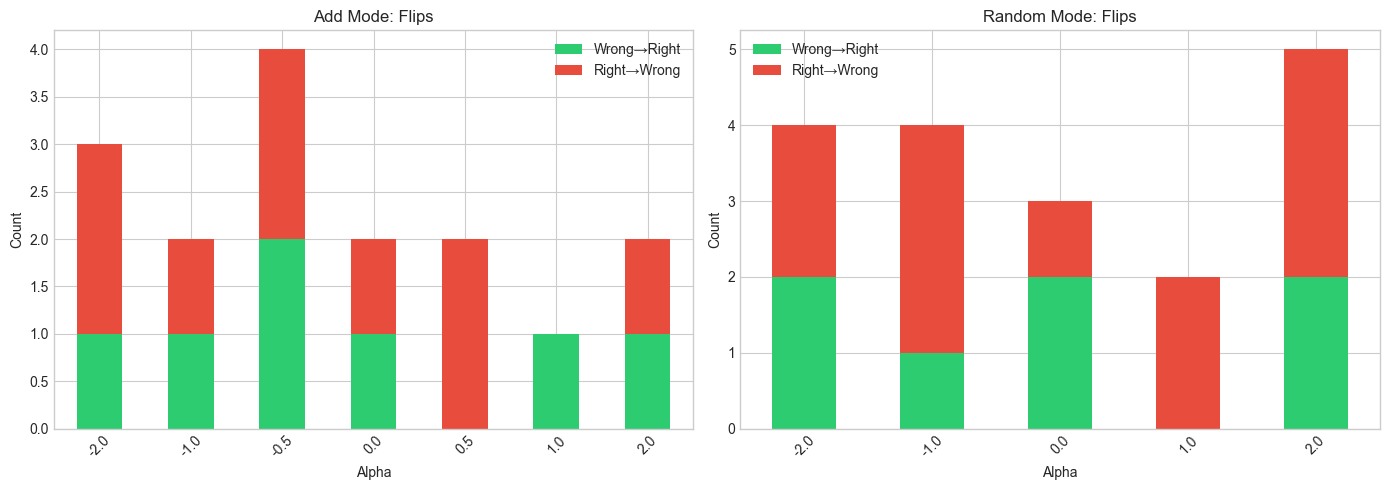

In [12]:
fig, axes = plot_flip_bars(df, save_path=Path('../results/figures/flip_bars.pdf'))
plt.show()

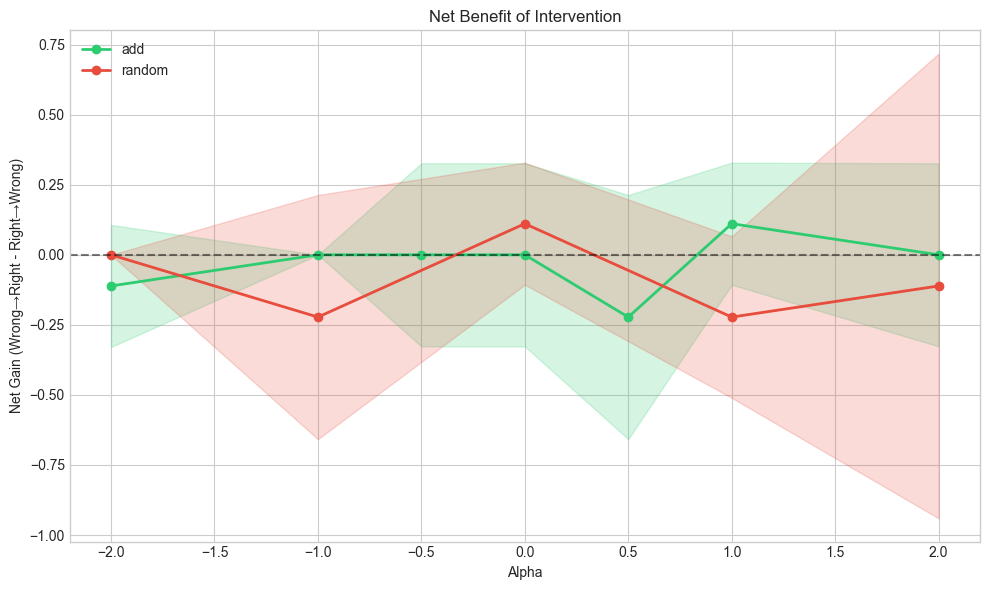

In [13]:
fig, ax = plot_net_gain_line(df, save_path=Path('../results/figures/net_gain_line.pdf'))
plt.show()

## 6. ARA (Rescue) Analysis

Tests the Add-Remove-Add paradigm:
- Pass 1: Add reasoning direction
- Pass 2: Remove (lesion) direction
- Pass 3: Add again (rescue)

**Key metrics:**
- Consistency = P(Pass1 answer == Pass3 answer) - should be high if intervention is causal
- Recovery = P(Pass1 answer != Pass2 answer) - measures if lesion has effect

In [14]:
# ARA Summary Table
if len(ara_df) > 0:
    ara_summary = create_ara_summary_table(ara_df)
    print('ARA Results Summary:')
    display(ara_summary)
else:
    print('No ARA data available')

ARA Results Summary:


,Model,Dataset,N,Pass1 Acc,Pass2 Acc,Pass3 Acc,Consistency,Recovery
0,Llama-3.1-8B-Instruct,arc,20,0.85,0.85,0.85,1.00,0.00
1,Llama-3.1-8B-Instruct,gsm8k,20,0.15,0.20,0.15,1.00,0.05
2,Llama-3.1-8B-Instruct,mmlu_pro,20,0.40,0.40,0.40,1.00,0.00
3,Mistral-7B-Instruct-v0.3,arc,20,0.75,0.75,0.75,1.00,0.00
4,Mistral-7B-Instruct-v0.3,gsm8k,20,0.15,0.15,0.15,1.00,0.00
5,Mistral-7B-Instruct-v0.3,mmlu_pro,20,0.45,0.45,0.45,1.00,0.00
6,Qwen2.5-7B-Instruct,arc,20,0.80,0.80,0.80,1.00,0.00
7,Qwen2.5-7B-Instruct,gsm8k,20,0.25,0.20,0.30,0.95,0.05
8,Qwen2.5-7B-Instruct,mmlu_pro,20,0.60,0.60,0.60,1.00,0.00


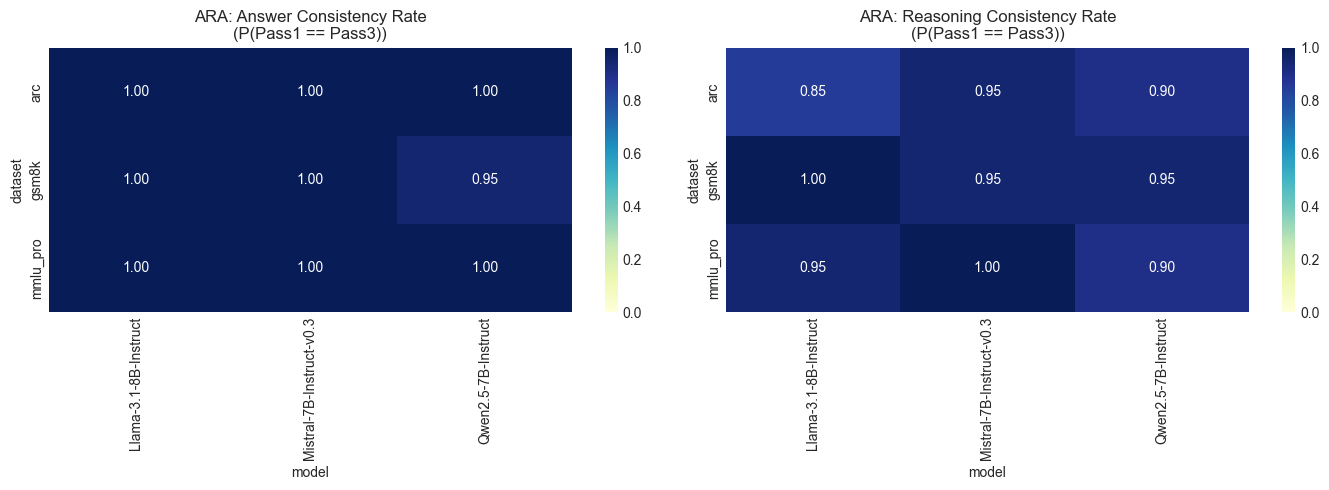

In [15]:
# ARA Consistency Heatmap
if len(ara_df) > 0:
    fig, axes = plot_ara_consistency(ara_df, save_path=Path('../results/figures/ara_consistency.pdf'))
    plt.show()

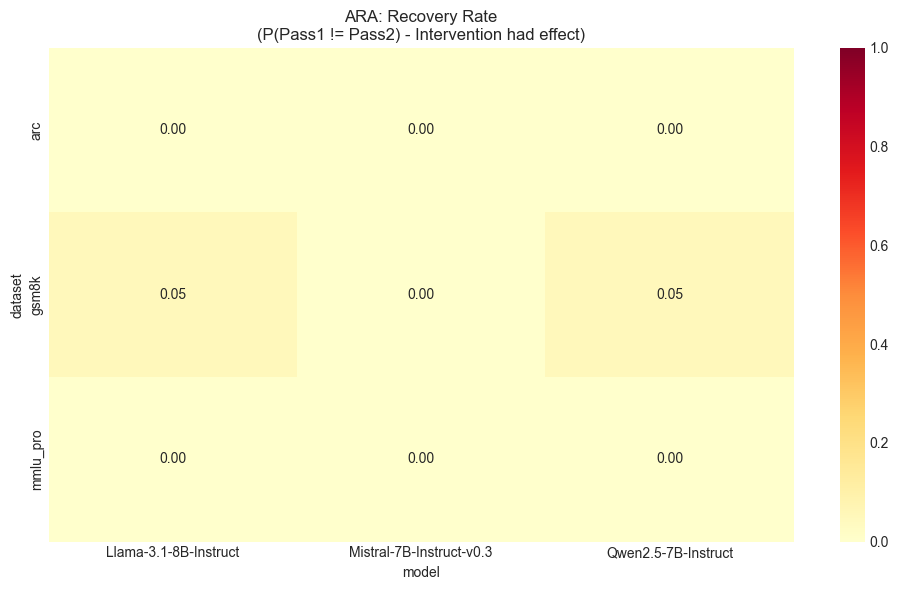

In [16]:
# ARA Recovery Heatmap
if len(ara_df) > 0:
    fig, ax = plot_ara_recovery(ara_df, save_path=Path('../results/figures/ara_recovery.pdf'))
    plt.show()

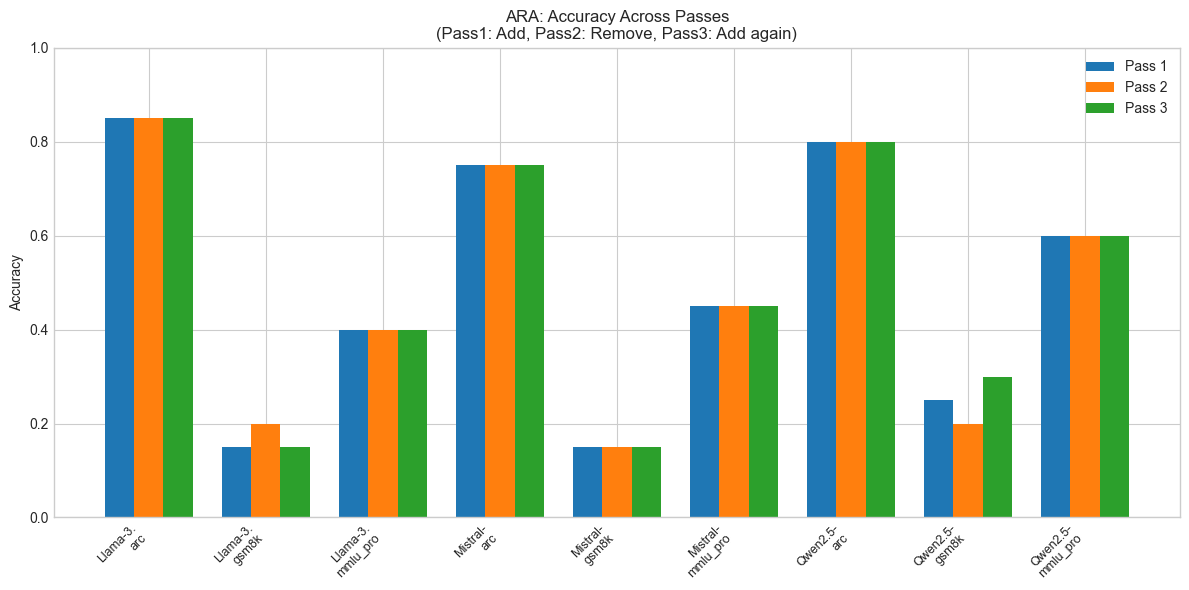

In [17]:
# ARA Accuracy Progression
if len(ara_df) > 0:
    fig, ax = plot_ara_accuracy_progression(ara_df, save_path=Path('../results/figures/ara_accuracy_progression.pdf'))
    plt.show()

In [18]:
# ARA Statistical Tests
if len(ara_df) > 0:
    ara_tests = run_ara_statistical_tests(ara_df)
    print('\n=== ARA Statistical Tests ===')
    for name, result in ara_tests.items():
        print(f'\n{name}:')
        for k, v in result.items():
            print(f'  {k}: {v}')


=== ARA Statistical Tests ===

consistency_vs_chance:
  mean: 0.9944444444444444
  std: 0.01666666666666668
  t_stat: 88.99999999999991
  p_value: 1.417391108844071e-13
  interpretation: High consistency suggests reproducible intervention effect

recovery_vs_zero:
  mean: 0.011111111111111112
  std: 0.022047927592204922
  t_stat: 1.511857892036909
  p_value: 0.08451010150958493
  interpretation: Low recovery suggests intervention does not reliably change output


## 7. Statistical Tests - McNemar

In [19]:
mcnemar_pos = run_mcnemar_tests(df, mode='add', alpha_filter=0)
print('McNemar Test: Add Mode (α > 0) - Testing Sufficiency')
display(mcnemar_pos)

McNemar Test: Add Mode (α > 0) - Testing Sufficiency


,model,dataset,mode,wrong_to_right,right_to_wrong,net_gain,p_value,significant_0.05,significant_0.01
0,Llama-3.1-8B-Instruct,arc,add,0,0,0,1.00,False,False
1,Llama-3.1-8B-Instruct,gsm8k,add,0,3,-3,0.25,False,False
2,Llama-3.1-8B-Instruct,mmlu_pro,add,0,0,0,1.00,False,False
3,Mistral-7B-Instruct-v0.3,arc,add,0,0,0,1.00,False,False
4,Mistral-7B-Instruct-v0.3,gsm8k,add,0,0,0,1.00,False,False
5,Mistral-7B-Instruct-v0.3,mmlu_pro,add,0,0,0,1.00,False,False
6,Qwen2.5-7B-Instruct,arc,add,0,0,0,1.00,False,False
7,Qwen2.5-7B-Instruct,gsm8k,add,2,0,2,0.50,False,False
8,Qwen2.5-7B-Instruct,mmlu_pro,add,0,0,0,1.00,False,False


In [28]:
mcnemar_neg = run_mcnemar_tests(df, mode='add', alpha_filter=-1)
print('McNemar Test: Add Mode (α < 0) - Testing Necessity')
display(mcnemar_neg)

McNemar Test: Add Mode (α < 0) - Testing Necessity


,model,dataset,mode,wrong_to_right,right_to_wrong,net_gain,p_value,significant_0.05,significant_0.01
0,Llama-3.1-8B-Instruct,arc,add,0,0,0,1.0,False,False
1,Llama-3.1-8B-Instruct,gsm8k,add,1,2,-1,1.0,False,False
2,Llama-3.1-8B-Instruct,mmlu_pro,add,0,0,0,1.0,False,False
3,Mistral-7B-Instruct-v0.3,arc,add,0,0,0,1.0,False,False
4,Mistral-7B-Instruct-v0.3,gsm8k,add,1,0,1,1.0,False,False
5,Mistral-7B-Instruct-v0.3,mmlu_pro,add,0,0,0,1.0,False,False
6,Qwen2.5-7B-Instruct,arc,add,0,0,0,1.0,False,False
7,Qwen2.5-7B-Instruct,gsm8k,add,2,3,-1,1.0,False,False
8,Qwen2.5-7B-Instruct,mmlu_pro,add,0,0,0,1.0,False,False


## 8. Statistical Tests - Sign Test

In [29]:
sign_pos = run_sign_test(df, mode='add', alpha_filter=0)
print('Sign Test: Add Mode (α > 0)')
print(f"Positive: {sign_pos['n_positive']}, Negative: {sign_pos['n_negative']}, p={sign_pos['p_value']:.4f}")

sign_neg = run_sign_test(df, mode='add', alpha_filter=-1)
print('\nSign Test: Add Mode (α < 0)')
print(f"Positive: {sign_neg['n_positive']}, Negative: {sign_neg['n_negative']}, p={sign_neg['p_value']:.4f}")

Sign Test: Add Mode (α > 0)
Positive: 2, Negative: 2, p=1.0000

Sign Test: Add Mode (α < 0)
Positive: 1, Negative: 2, p=1.0000


## 9. Statistical Tests - t-test vs Zero

In [30]:
ttest_pos = run_ttest_vs_zero(df, mode='add', alpha_filter=0)
print('t-test: Add Mode (α > 0) vs 0')
print(f"Mean: {ttest_pos['mean']:.4f}, t={ttest_pos['t_stat']:.3f}, p={ttest_pos['p_value']:.4f}")

ttest_neg = run_ttest_vs_zero(df, mode='add', alpha_filter=-1, alternative='less')
print('\nt-test: Add Mode (α < 0) - Testing Mean < 0')
print(f"Mean: {ttest_neg['mean']:.4f}, t={ttest_neg['t_stat']:.3f}, p={ttest_neg['p_value']:.4f}")

t-test: Add Mode (α > 0) vs 0
Mean: -0.0019, t=-0.372, p=0.7130

t-test: Add Mode (α < 0) - Testing Mean < 0
Mean: -0.0019, t=-0.570, p=0.2868


## 10. Statistical Tests - Mann-Whitney U (Specificity)

In [31]:
mw_results = []
for alpha in sorted(df['alpha'].unique()):
    mw = run_mann_whitney(df, alpha_value=alpha)
    mw['alpha'] = alpha
    mw_results.append(mw)
mw_df = pd.DataFrame(mw_results)
print('Mann-Whitney U: Add vs Random by Alpha')
display(mw_df[['alpha', 'add_mean', 'random_mean', 'p_value', 'effect_size_r', 'significant']])

Mann-Whitney U: Add vs Random by Alpha


,alpha,add_mean,random_mean,p_value,effect_size_r,significant
0,-2.0,-5.555556e-03,0.000000,0.374063,0.111111,False
1,-1.0,0.000000e+00,-0.011111,0.374063,-0.111111,False
2,-0.5,NaN,NaN,1.000000,NaN,NaN
3,0.0,1.156482e-17,0.005556,0.683458,0.086420,False
4,0.5,NaN,NaN,1.000000,NaN,NaN
5,1.0,5.555556e-03,-0.011111,0.102891,-0.308642,False
6,2.0,-1.156482e-17,-0.005556,1.000000,0.000000,False


## 11. Effect Sizes (Cohen's d)

In [32]:
effect_sizes = compute_effect_sizes(df)
display(effect_sizes)

,dataset,model,add_mean,random_mean,cohens_d,interpretation
0,arc,Llama-3.1-8B-Instruct,0.000000,0.00,NaN,N/A
1,arc,Mistral-7B-Instruct-v0.3,0.000000,0.00,NaN,N/A
2,arc,Qwen2.5-7B-Instruct,0.000000,0.00,NaN,N/A
3,gsm8k,Llama-3.1-8B-Instruct,-0.021429,-0.04,0.332026,small
4,gsm8k,Mistral-7B-Instruct-v0.3,0.007143,0.00,0.487950,small
5,gsm8k,Qwen2.5-7B-Instruct,0.000000,0.00,0.000000,negligible
6,mmlu_pro,Llama-3.1-8B-Instruct,0.000000,0.00,NaN,N/A
7,mmlu_pro,Mistral-7B-Instruct-v0.3,0.000000,0.00,NaN,N/A
8,mmlu_pro,Qwen2.5-7B-Instruct,0.000000,0.00,NaN,N/A


## 12. Dose-Response Regression

In [33]:
dr_add = run_dose_response_regression(df, mode='add')
dr_random = run_dose_response_regression(df, mode='random')

print('Dose-Response: Δ = β₀ + β₁·α')
print(f"\nAdd: slope={dr_add['slope']:.4f}, R²={dr_add['r_squared']:.4f}, p={dr_add['p_value']:.4f}")
print(f"Random: slope={dr_random['slope']:.4f}, R²={dr_random['r_squared']:.4f}, p={dr_random['p_value']:.4f}")

Dose-Response: Δ = β₀ + β₁·α

Add: slope=0.0011, R²=0.0035, p=0.6429
Random: slope=-0.0011, R²=0.0023, p=0.7564


## 13. Complete Summary

In [34]:
all_results = run_all_statistical_tests(df)
print_results_summary(all_results)


STATISTICAL TEST RESULTS SUMMARY

--- McNemar's Test (Add Mode, α > 0) ---
                      model   dataset mode  wrong_to_right  right_to_wrong  net_gain  p_value  significant_0.05  significant_0.01
0     Llama-3.1-8B-Instruct       arc  add               0               0         0     1.00             False             False
1     Llama-3.1-8B-Instruct     gsm8k  add               0               3        -3     0.25             False             False
2     Llama-3.1-8B-Instruct  mmlu_pro  add               0               0         0     1.00             False             False
3  Mistral-7B-Instruct-v0.3       arc  add               0               0         0     1.00             False             False
4  Mistral-7B-Instruct-v0.3     gsm8k  add               0               0         0     1.00             False             False
5  Mistral-7B-Instruct-v0.3  mmlu_pro  add               0               0         0     1.00             False             False
6       Qwen2.

## 14. Save Results

In [27]:
output_dir = Path('../results/figures')
all_results['mcnemar_add_positive'].to_csv(output_dir / 'mcnemar_positive.csv', index=False)
all_results['mcnemar_add_negative'].to_csv(output_dir / 'mcnemar_negative.csv', index=False)
all_results['mann_whitney'].to_csv(output_dir / 'mann_whitney.csv', index=False)
all_results['effect_sizes'].to_csv(output_dir / 'effect_sizes.csv', index=False)
all_results['dose_response'].to_csv(output_dir / 'dose_response.csv', index=False)
if len(ara_df) > 0:
    ara_df.to_csv(output_dir / 'ara_results.csv', index=False)
print('Results saved to ../results/figures/')

Results saved to ../results/figures/


## 15. Conclusions

### Sufficiency (α > 0)
- Does adding the reasoning direction improve performance?

### Necessity (α < 0) 
- Does lesioning the reasoning direction harm performance?

### Specificity (Add vs Random)
- Is the learned direction better than random directions?

### Rescue (ARA)
- Does Add-Remove-Add show consistent and reversible effects?